In [1]:
"""
Ackermann Path Generation Tools

Contains functions to make it easy to plan paths of an Ackermann-steering car.
Ackermann-steering cars travel in a circle when set to a constant steering angle.
"""

import numpy as np
import collections

DEFAULT_WHEEL_BASE = 0.325

In [2]:
%%javascript
// Ctrl+Enter shall not lose focus.
IPython.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-enter', {
    help : "run cell and keep focus",
    handler : function (event) {
        IPython.notebook.execute_cell();
        IPython.notebook.edit_mode();
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
"""ipython notebook imports"""
from matplotlib import pyplot as pp
from ipywidgets import interact, FloatSlider

In [4]:
def turning_radius(wheel_base, steering_angle):
    """Get the turning radius of the car at a certain steering angle.
    Args:
        wheel_base: Distance between front and back axel in meters.
        steering_angle: Steering angle in radians.
                        Should probably be limited to [-pi, pi].
    Returns:
        The turning radius in meters. Return inf if steering_angle is 0.
    """
    if steering_angle == 0.:
        return float("inf")
    return abs(wheel_base / np.tan(steering_angle))

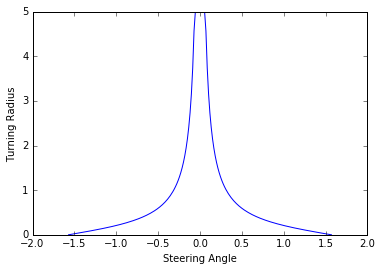

In [5]:
def show():
    angles = np.linspace(-np.pi / 2., np.pi / 2., num=200)
    turning_radii = [turning_radius(DEFAULT_WHEEL_BASE, angle) for angle in angles]
    # Clamp for viewing pleasure
    turning_radii = np.minimum(turning_radii, 5)
    pp.plot(angles, turning_radii)
    pp.xlabel("Steering Angle")
    pp.ylabel("Turning Radius")
show()

In [6]:
def ack_step_origin(wheel_base, steering_angle, travel_distance):
    """Move a car starting at the origin along its path.
    Coordinate System:
        +X is "to the right" on paper and "forward" for the car.
        +Y is "up" on paper and "left turn" for the car.
        Angles proceed CCW.
    Args:
        wheel_base: Distance between front and back axel in meters.
        steering_angle: Steering angle in radians. Positive means left.
                        Should probably be limited to [-pi, pi].
        travel_distance: Distance the car should travel in meters.
    Returns:
        An np array of [x, y, heading] (shape=(3,)).
    """
    if steering_angle == 0.:
        x, y, heading = travel_distance, 0., 0.
        return (x, y, heading)
    radius = turning_radius(wheel_base, steering_angle)
    # Angle of the turning circle spanned by the arc that the car takes.
    travel_angle = travel_distance / radius
    # circumference = 2 * np.pi * radius
    # travel_angle2 = (travel_distance / circumference) * 2 * np.pi
    # assert np.isclose(travel_angle, travel_angle2), [travel_angle, travel_angle2]
    x = radius * np.sin(travel_angle)
    y = radius * (1 - np.cos(travel_angle))
    heading = travel_angle
    if steering_angle < 0:
        y *= -1
        heading *= -1
    return np.array([x, y, heading])
    

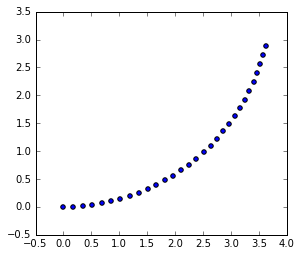

In [7]:
"""Plot of a single arc trajectory."""
def show(steering_angle):
    distances = np.linspace(0., 5., num=30)
    poses = [ack_step_origin(DEFAULT_WHEEL_BASE, steering_angle, distance) for distance in distances]
    poses = np.array(poses)
    xs, ys, headings = poses[:,0], poses[:,1], poses[:,2]
    pp.gca().set_aspect('equal', adjustable='box')
    pp.scatter(xs, ys)

interact(show, steering_angle=FloatSlider(np.deg2rad(5), min=-np.deg2rad(45), max=np.deg2rad(45), step=0.001))
pass

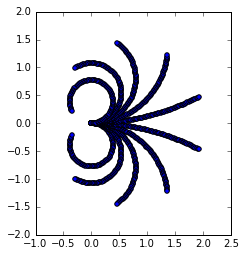

In [8]:
"""Plot multiple arcs or wavefronts of many possible arc trajectories.
Scrub display_bias to change the visualization.
Near 0 shows a few candidate paths.
Middling values show all explorable space within some distance.
Near 1 shows wavefronts of many possible arc trajectories.
"""
def show(display_bias):
    maxangle = np.deg2rad(40)
    display_count = 100
    angles = np.linspace(-maxangle, maxangle, num=max(1, display_bias * display_count))
    distances = np.linspace(0, 2, num=max(1, (1 - display_bias) * display_count))
    poses = [ack_step_origin(DEFAULT_WHEEL_BASE, angle, distance)
            for angle in angles
            for distance in distances]
    poses = np.array(poses)
    xs, ys, headings = poses[:,0], poses[:,1], poses[:,2]
    pp.gca().set_aspect('equal', adjustable='box')
    pp.scatter(xs, ys)

interact(show, display_bias=FloatSlider(0.1, min=0, max=1, step=0.001))
pass

In [9]:
def rotate2d(x, y, angle):
    """Rotate a 2d coordinate around the origin.
    Returns: np array of [x', y']
    """
    return np.array([x * np.cos(angle) - y * np.sin(angle),
                     y * np.cos(angle) + x * np.sin(angle)])

def ack_step(wheel_base, steering_angle, travel_distance, start_x, start_y, start_heading):
    """Move a car starting anywhere along its path.
    Works by calling ack_step_origin and then transforming to the start.
    Coordinate System: Same as ack_step_origin.
    Args:
        wheel_base: Distance between front and back axel in meters.
        steering_angle: Steering angle in radians.
                        Should probably be limited to [-pi, pi].
        travel_distance: Distance the car should travel in meters.
        startx, starty, startheading: Starting pose of the car.
    Returns: np array of [x, y, heading].
    """
    x_o, y_o, heading_o = ack_step_origin(wheel_base, steering_angle, travel_distance)
    # Rotate and then translate.
    x_1, y_1 = rotate2d(x_o, y_o, start_heading)
    x, y, heading = x_1 + start_x, y_1 + start_y, heading_o + start_heading
    return np.array([x, y, heading])

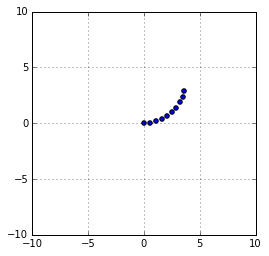

In [10]:
"""Plot of a single arc trajectory from an arbitrary starting position."""
def show(steering_angle, start_x, start_y, start_heading):
    distances = np.linspace(0., 5., num=10)
    start = (start_x, start_y, start_heading)
    poses = [ack_step(DEFAULT_WHEEL_BASE, steering_angle, distance, *start) for distance in distances]
    poses = np.array(poses)
    xs, ys, headings = poses[:,0], poses[:,1], poses[:,2]
    board_size = 10
    pp.xlim([-board_size, board_size])
    pp.ylim([-board_size, board_size])
    pp.scatter(xs, ys)
    pp.gca().set_aspect('equal', adjustable='box')
    pp.grid()

interact(show,
         steering_angle=FloatSlider(np.deg2rad(5), min=-np.deg2rad(45), max=np.deg2rad(45), step=0.001),
         start_x=FloatSlider(0, min=-10, max=10, step=0.001),
         start_y=FloatSlider(0, min=-10, max=10, step=0.001),
         start_heading=FloatSlider(0, min=-np.deg2rad(180), max=np.deg2rad(180), step=0.001))
pass

In [11]:
def path_constant_curve(wheel_base, steering_angle, travel_distance, npoints, start_x, start_y, start_heading):
    """Create a constant curvature path.
    Args:
        npoints: Number of points in path. Must be > 2.
    npoints: How many points the result should contain.
    Returns: np array array of waypoints  (shape=(N,3)).
             [[x1, y1, heading1], [x2, y2, heading2], ...]
    """
    assert(npoints > 2)
    travel_step = travel_distance / float(npoints-1)
    waypoints = []
    x, y, heading = start_x, start_y, start_heading
    waypoints.append((x, y, heading))
    for _ in xrange(npoints-1):
        x, y, heading = ack_step(wheel_base, steering_angle, travel_step, x, y, heading)
        waypoints.append((x, y, heading))
    return np.array(waypoints)

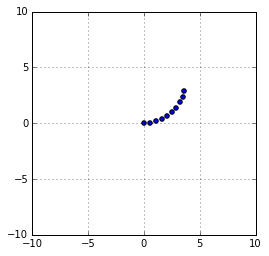

In [12]:
"""Plot of a constant curvature arc trajectory."""
def show(steering_angle, travel_distance, npoints, start_x, start_y, start_heading):
    distances = np.linspace(0., 5., num=20)
    start = (start_x, start_y, start_heading)
    npoints = int(npoints)
    poses = path_constant_curve(
        DEFAULT_WHEEL_BASE, steering_angle, travel_distance,
        npoints, start_x, start_y, start_heading)
    poses = np.array(poses)
    xs, ys = poses[:,0], poses[:,1]
    board_size = 10
    pp.xlim([-board_size, board_size])
    pp.ylim([-board_size, board_size])
    pp.scatter(xs, ys)
    pp.gca().set_aspect('equal', adjustable='box')
    pp.grid()

interact(show,
         steering_angle=FloatSlider(np.deg2rad(5), min=-np.deg2rad(45), max=np.deg2rad(45), step=0.001),
         travel_distance=FloatSlider(5, min=0., max=20., step=0.001),
         npoints=FloatSlider(10, min=1, max=100, step=1),
         start_x=FloatSlider(0, min=-10, max=10, step=0.001),
         start_y=FloatSlider(0, min=-10, max=10, step=0.001),
         start_heading=FloatSlider(0, min=-np.deg2rad(180), max=np.deg2rad(180), step=0.001))
pass

In [13]:
"""How fast is it?"""
%timeit path_constant_curve(DEFAULT_WHEEL_BASE, steering_angle=.1, travel_distance=5., npoints=20, start_x=1, start_y=2, start_heading=3)
%timeit path_constant_curve(DEFAULT_WHEEL_BASE, steering_angle=.1, travel_distance=5., npoints=200, start_x=1, start_y=2, start_heading=3)
%timeit path_constant_curve(DEFAULT_WHEEL_BASE, steering_angle=.1, travel_distance=5., npoints=2000, start_x=1, start_y=2, start_heading=3)

1000 loops, best of 3: 298 µs per loop
100 loops, best of 3: 2.82 ms per loop
10 loops, best of 3: 27.9 ms per loop


In [14]:
def paths_fan(wheel_base, steering_angle_min, steering_angle_max,
              npaths, travel_distance, npoints_perpath,
              start_x, start_y, start_heading):
    """Create a bunch of constant curve paths.
    Returns: An array of np arrays of waypoints.
    """
    paths = []
    for steering_angle in np.linspace(steering_angle_min, steering_angle_max, num=npaths):
        paths.append(path_constant_curve(wheel_base,
                                        steering_angle, travel_distance, npoints_perpath,
                                        start_x, start_y, start_heading))
    return paths

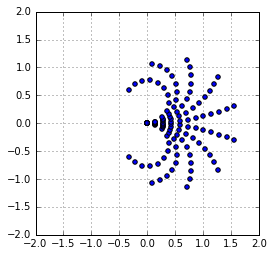

In [15]:
"""Plot of fan paths."""
def show(wheel_base, steering_angle_max, npaths, travel_distance, npoints_perpath, start_x, start_y, start_heading):
    distance = travel_distance
    start = (start_x, start_y, start_heading)
    npaths = int(npaths)
    npoints_perpath = int(npoints_perpath)
    paths = paths_fan(wheel_base,
                      -steering_angle_max, steering_angle_max, npaths,
                      distance, npoints_perpath, start_x, start_y, start_heading)
    poses = np.vstack(paths)
    xs, ys = poses[:,0], poses[:,1]
    board_size = 2
    pp.xlim([-board_size, board_size])
    pp.ylim([-board_size, board_size])
    pp.scatter(xs, ys)
    pp.gca().set_aspect('equal', adjustable='box')
    pp.grid()

interact(show,
         wheel_base=FloatSlider(DEFAULT_WHEEL_BASE, min=0.01, max=1.5, step=0.001),
         steering_angle_max=FloatSlider(np.deg2rad(40), min=np.deg2rad(0), max=np.deg2rad(90), step=0.001),
         npaths=FloatSlider(10, min=1, max=50, step=1),
         travel_distance=FloatSlider(1.6, min=0., max=20., step=0.001),
         npoints_perpath=FloatSlider(12, min=1, max=100, step=1),
         start_x=FloatSlider(0, min=-10, max=10, step=0.001),
         start_y=FloatSlider(0, min=-10, max=10, step=0.001),
         start_heading=FloatSlider(0, min=-np.deg2rad(180), max=np.deg2rad(180), step=0.001))
pass

In [16]:
def paths_forking(wheel_base, steering_angle_min, steering_angle_max,
              npaths, nfork, step_distance, fork_distance, travel_distance,
              start_x, start_y, start_heading):
    """Create a tree of paths that fork.
    Note that this blows up in runtime exponentially. Be careful with the parameters.
    Args:
        npaths: Number of paths to start with.
        nfork: Number of paths stemming from each fork.
        step_distance: Distance between each point.
        fork_distance: Distance between forks in meters.
        travel_distance: Length of each path in meters.
    Returns: An array of np arrays of waypoints.
    """
    assert(step_distance > 0)
    assert(travel_distance > 0)
    assert(fork_distance > 0)
    State = collections.namedtuple("State",
        ["steering_angle", "waypoints", "length", "last_fork"])
    # State.waypoints is a list of waypoints.
    # A waypoint is [x, y, heading].
    # last_fork is the length at which the last fork was.

    # States which need to grow.
    states = []
    # States which are done.
    states_done = []
    
    # Start the first paths.
    for steering_angle in np.linspace(steering_angle_min, steering_angle_max, num=npaths):
        waypoints = np.array([[start_x, start_y, start_heading]])
        states.append(State(steering_angle, waypoints, length=0, last_fork=0))

    # Loop until all states have moved to states_done.
    while len(states):
        last_states = states
        states = []
        for state in last_states:
            done_now = state.length >= travel_distance
            fork_now = state.length - state.last_fork >= fork_distance
            if done_now:
                # Move the state to done.
                states_done.append(state)
            elif fork_now:
                # Fork into new paths with different steering angles.
                for steering_angle in np.linspace(steering_angle_min, steering_angle_max, num=nfork):
                    states.append(state._replace(
                            steering_angle=steering_angle,
                            last_fork=state.length))
            else:
                # Step the path by step_distance.
                x, y, heading = state.waypoints[-1]
                x, y, heading = ack_step(wheel_base, state.steering_angle, step_distance, x, y, heading)
                waypoints_new = np.append(state.waypoints, [[x, y, heading]], axis=0)
                state_new = state._replace(
                    waypoints=waypoints_new,
                    length=state.length + step_distance)
                states.append(state_new)
                
    return [state.waypoints for state in states_done]

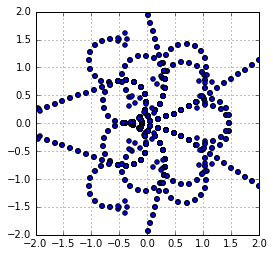

In [17]:
"""Plot of fan paths."""
def show(wheel_base, steering_angle_max,
              npaths, nfork, step_distance, fork_distance, travel_distance,
              start_x, start_y, start_heading):
    distance = travel_distance
    start = (start_x, start_y, start_heading)
    paths = paths_forking(wheel_base, -steering_angle_max, steering_angle_max,
              npaths, nfork, step_distance, fork_distance, travel_distance,
              start_x, start_y, start_heading)
    poses = np.vstack(paths)
    xs, ys = poses[:,0], poses[:,1]
    board_size = 2
    pp.xlim([-board_size, board_size])
    pp.ylim([-board_size, board_size])
    pp.scatter(xs, ys)
    pp.gca().set_aspect('equal', adjustable='box')
    pp.grid()

interact(show,
         wheel_base=FloatSlider(DEFAULT_WHEEL_BASE, min=0.01, max=1.5, step=0.001),
         steering_angle_max=FloatSlider(np.deg2rad(40), min=np.deg2rad(0), max=np.deg2rad(90), step=0.001),
         npaths=FloatSlider(6, min=1, max=50, step=1),
         nfork=FloatSlider(10, min=1, max=20, step=1),
         step_distance=FloatSlider(.15, min=.05, max=.75, step=0.001),
         fork_distance=FloatSlider(1.28, min=0, max=3, step=0.001),
         travel_distance=FloatSlider(2.2, min=0., max=10., step=0.001),
         start_x=FloatSlider(-.4, min=-10, max=10, step=0.001),
         start_y=FloatSlider(0, min=-10, max=10, step=0.001),
         start_heading=FloatSlider(0, min=-np.deg2rad(180), max=np.deg2rad(180), step=0.001))
pass